In [1]:
CUDA_DEVICE = "1"
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_DEVICE

In [2]:
import numpy as np
from PIL import Image
import json
import copy
import argparse
from tqdm import tqdm
import notebook_mesh_utils as nu
import matplotlib.pyplot as plt
import tomopy
import cv2


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#metadata_fp = '/home/beams/S1IDUSER/new_data/alshibli_nov22/F75_sp1_tomo/F75_sp1_tomo_TomoFastScan.dat'
#override_path = '/home/beams/S1IDUSER/mnt/s1c/alshibli_nov22/tomo/F75_sp1_tomo'

metadata_fp = '/home/beams/S1IDUSER/new_data/alshibli_nov22/F50_sp5_tomo/F50_sp5_tomo_TomoFastScan.dat'
override_path = '/home/beams/S1IDUSER/mnt/s1c/alshibli_nov22/tomo/F50_sp5_tomo'

scans = nu.extract_scan_data(metadata_fp, override_path)
nu.print_avail_scans(scans)

[0]: [278248, 280078]
[1]: [280079, 281909]
[2]: [281910, 283740]


In [5]:
scan = scans[1]
scan

ScanMetaData(img_range=[280079, 281909], omega=array([-180. , -179.8, -179.6, ...,  179.6,  179.8,  180. ]), img_dir='/home/beams/S1IDUSER/mnt/s1c/alshibli_nov22/tomo/F50_sp5_tomo', img_prefix='F50_sp5_tomo')

In [14]:
scan_data = await nu.load_images(scan, 10, False)

Loading Imgs: 100%|██████████| 1831/1831 [00:04<00:00, 443.55it/s]


In [15]:
print(scan_data.projs.shape)
print(scan_data.dark_fields.shape)
print(scan_data.white_fields.shape)
print(scan_data.omega.shape)

(1200, 1801, 1920)
(1200, 10, 1920)
(1200, 20, 1920)
(1801,)


In [16]:
scan_data.projs = scan_data.projs.swapaxes(0,1)
scan_data.dark_fields = scan_data.dark_fields.swapaxes(0,1)
scan_data.white_fields = scan_data.white_fields.swapaxes(0,1)

In [17]:
nu.crop_projs(scan_data, [200, 1720])

In [20]:
proj = tomopy.normalize(scan_data.projs, scan_data.white_fields, scan_data.dark_fields)
#proj = tomopy.minus_log(proj)
print(proj.shape)

(1801, 1200, 1520)


In [23]:
rot_center = tomopy.find_center(proj, scan_data.omega, init=scan_data.projs.shape[2]//2, ind=300, tol=0.5)

In [24]:
print(rot_center)

[1045.]


In [25]:
print(scan_data.projs.shape[2]/2)
#print(rot_center)
print(proj.shape)
print(scan_data.omega.shape)
#rot_center = scan_data.projs.shape[2]//2

760.0
(1801, 1200, 1520)
(1801,)


In [26]:
adjusted = proj * 1.5

In [55]:
options = {'proj_type': 'linear', 'method': 'FBP_CUDA'}
recon = tomopy.recon(adjusted[:-1],
                     scan_data.omega[:-1],
                     center=adjusted.shape[2]//2,
                     algorithm=tomopy.astra,
                     options=options,
                     ncore=20)

In [64]:
recon_clipped = np.clip(recon, 0, 0.002)

In [65]:
recon_no_ring = tomopy.misc.corr.circ_mask(recon_clipped, 0, ratio=0.95)

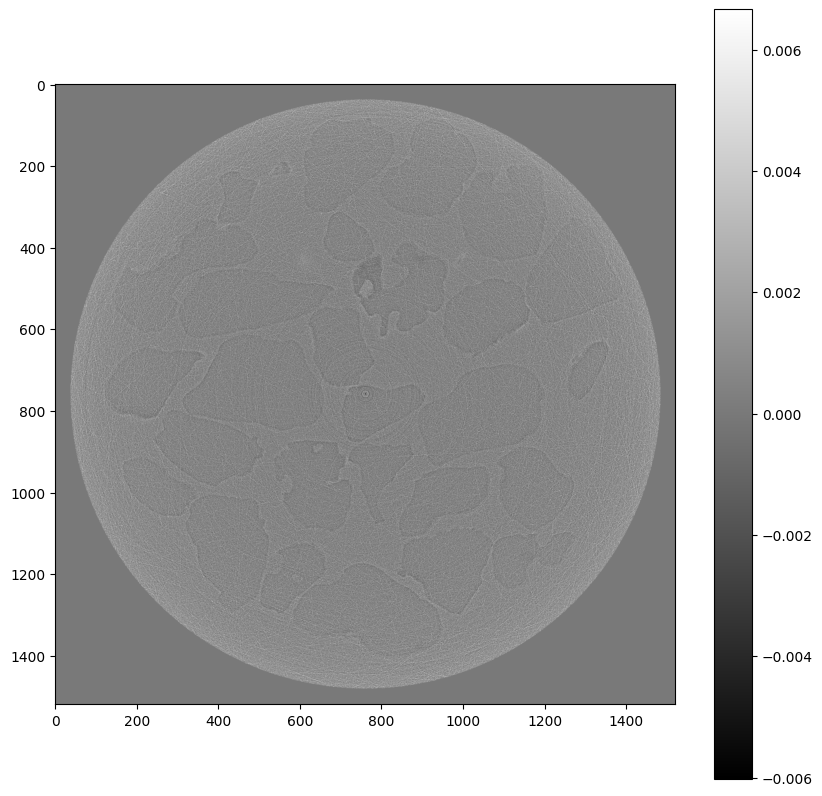

In [66]:
_ = nu.plot_recon(recon, 150) #, [0, 0.0002])